# Discrete solitons, twin soliton

We use a variational ansatz via pullback in the representation
of the characteristic function in the quantum phase space


<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
<br>nonlinearxwaves@gmail.com<br>
@created 3 may 2021<br>
@version 27 mar 2023

## Disable GPU

In [1]:
import os

In [2]:
DisableGPU=True
if DisableGPU:
    try:
        # Disable all GPUS        
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        #tf.config.set_visible_devices([], 'GPU')
        #visible_devices = tf.config.get_visible_devices()
        #for device in visible_devices:
        #    assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
else:
    print("Nothing to be done")

## Import and setup

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from thqml import phasespace as qx
from thqml import quantumsolitons as qs
import random

2023-03-29 07:58:18.797593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-29 07:58:18.797612: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-29 07:58:21.712804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-29 07:58:21.712830: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-29 07:58:21.712849: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2023-03-29 07:58:21.713262: I tensorflow/core/platform/cpu_feature_guard.c

#### Default precision (tr_real and np_real as tf.float32 np.float32 or tf.float64 np.floatt)

In [4]:
tf_real = tf.float32
np_real = np.float32

In [5]:
np.set_printoptions(precision=4)

#### Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Parameters

In [7]:
max_number_epochs=1000

In [8]:
period_display_epoch=max_number_epochs/10

In [9]:
period_checkpoint_epoch=period_display_epoch

In [10]:
BosonSampling=False

In [11]:
# index of pair modes
nA=4
nB=5

## Target total number of bosons

In [12]:
Ntarget=10

## Dimension

In [13]:
N=20

### Number of modes

In [14]:
n=int(N/2)

## Value for potential

In [15]:
chi=-1

# Init the quantum soliton python module

In [16]:
# bose hubbard model has L=n and U=chi
qs.init({"n":n,"dtype":tf_real,"chi":chi,"L":n,"model":"nnt"})

Setting Bose-Hubbard model L=n (non periodical)


## Save filename

In [17]:
claudio_arrays_file='./dataBHT/dataBHTT_N'+repr(N)+'_Ntarget'+repr(Ntarget)+'U'+repr(qs.chi)+'A'+repr(nA)+'B'+repr(nB)+'/claudioarrays'
claudio_weights_file='./dataBHT/dataBHTT_N'+repr(N)+'_Ntarget'+repr(Ntarget)+'U'+repr(qs.chi)+'A'+repr(nA)+'B'+repr(nB)+'/claudiomodel'

In [18]:
print(claudio_arrays_file)
print(claudio_weights_file)

./dataBHT/dataBHTT_N20_Ntarget10U-1A4B5/claudioarrays
./dataBHT/dataBHTT_N20_Ntarget10U-1A4B5/claudiomodel


## Dummy training points

In [19]:
Nbatch=1
beta_np=1
xtrain = np.random.rand(Nbatch, N)-0.5
ytrain=np.zeros([Nbatch,1])
for i1 in range(Nbatch):
    ytrain[i1]=0

## Create model

In [20]:
vacuum = qx.VacuumLayer(N,dtype=tf_real, name="Vacuum")
dtarget=0.1*np.ones([N,1],dtype=np_real)
D=qx.TrainableDisplacementLayer(dtarget,dtype=tf_real,name="Displacement")

In [21]:
CovL=qx.CovarianceLayer(N, name="covariance",dtype=tf_real)
KinL=tf.keras.layers.Lambda(qs.kinetic_energy, name="K",dtype=tf_real)
BL=tf.keras.layers.Lambda(qs.gaussian_boson_numbers, name="Bosons",dtype=tf_real)
NL=tf.keras.layers.Lambda(tf.reduce_sum, dtype=tf_real,name="N")
VL=tf.keras.layers.Lambda(qs.potential_energy, dtype=tf_real,name="V")
HL=tf.keras.layers.Lambda(qs.total_energy, dtype=tf_real,name="H")
DL = qx.DifferentialGaussianLayer(N)

In [22]:
# Create the model
xin = tf.keras.layers.Input(N, dtype=tf_real, name="Input")
x1 = xin
a1 = None
x1, a1=qx.RandomLayer(N,dtype=tf_real,name="R")(x1,a1)
x1, a1 = D(x1,a1)
for ij in range(n):
        r_np=0.1*np.random.rand(1)
        n_squeeze=ij
        theta_np=2.0*np.pi*np.random.rand(1)
        x1, a1 = qx.SingleModeSqueezerLayer(N, r_np=r_np, 
                                   theta_np=theta_np, n_squeezed=n_squeeze, trainable=True, 
                                   dtype=tf_real, name="S"+repr(ij))(x1,a1)    
chir, chii = vacuum(x1, a1)
PSImodel = tf.keras.Model(inputs = xin, outputs=[chir, chii])    ## chose a random layer
cov, d, hessian = CovL(chir,chii, PSImodel)
Ktotal=KinL([cov,d]) 
[nboson,nboson2]=BL([cov,d,hessian])
Ntotal=NL(nboson)   
Vtotal=VL([nboson,nboson2])
Htotal=HL([Ktotal, Vtotal])
Ntarget_tf=tf.constant(Ntarget,dtype=tf_real)
nAtf=tf.gather_nd(nboson,[[0,nA]])[0]
nBtf=tf.gather_nd(nboson,[[0,nB]])[0]
nbdiff, dn, dn2 =DL(chir,chii, PSImodel)
# eigenvalues
e, v = tf.linalg.eig(cov)
expL=tf.exp(Htotal/n)
#expN=tf.exp(-nAtf*nBtf)
#expN=tf.exp(-nAtf-nBtf)
expN=tf.exp(-nAtf)
expDN=tf.square(nAtf-nBtf)
expDIFF=tf.gather_nd(dn2,[[nA,nB]])[0]

## Callbacks

In [23]:
# checkpoint function
def savecheckpoint(num_epochs):
    model.save_weights(claudio_weights_file+'_cp_'+repr(num_epochs))
    np.savez(claudio_arrays_file+'_cp_'+repr(num_epochs),history_H=history_H,history_N=history_N,
             #history_beta=history_beta,
             history_eig=history_eig,history_negativity=history_negativity,nbosonout=nbosonout[0].numpy())
    print('Made checkpoint at total epoch '+repr(num_epochs))

In [24]:
eig_model = tf.keras.Model(inputs = xin, outputs=e)    # print model
cov_model = tf.keras.Model(inputs = xin, outputs=cov)    # for covariance matrix
history_eig=[]
history_H=[]
history_N=[]
history_expN=[]
history_expDIFF=[]
#history_beta=[]
history_negativity=[]
# mask for negativity (entropy)
nmask=np.zeros(n)
nmask[nA]=1
# custom callback
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        global history_eig
        #keys = list(logs.keys())
        eigs=eig_model(xtrain)
        history_eig.append(eigs.numpy()[-1])
        history_H.append(logs.get("H"))
        history_N.append(logs.get("N"))
        history_expN.append(logs.get("expN"))
        history_expDIFF.append(logs.get("expDIFF"))
        #history_beta.append(LL.get_weights()[0])
        ENeg, _, _,_,_= qs.logarithmic_negativity(cov_model(xtrain).numpy(),nmask)
        history_negativity.append(ENeg)
        
        if np.mod(epoch, period_display_epoch)==0:
            print("Epoch "+repr(epoch)+
                  " of "+repr(max_number_epochs)+
                 " time "+repr(np.datetime64('now'))+
                  " H="+repr(np.around(logs.get("H"),decimals=3))+
                  " N="+repr(np.around(logs.get("N"),decimals=3))+
                  " DN="+repr(np.around(logs.get("expDIFF"),decimals=3)))
            
        # checkpoint at absolute value of the number of epochs
        if np.mod(epoch, period_checkpoint_epoch)==0:
            savecheckpoint(len(history_N)-1)

## Losses and metrics

In [25]:
model = tf.keras.Model(inputs = xin, outputs=expL)    # print model
model.add_loss(tf.reduce_mean(tf.square(Ntotal-Ntarget_tf)))
model.add_loss(expL)
model.add_loss(expN)
model.add_loss(expDN)
#model.add_loss(expDIFF)
model.add_metric(tf.reduce_mean(tf.square(Ntotal-Ntarget_tf)),name="Dn",aggregation="mean")
model.add_metric(expL,name="expDIFF",aggregation="mean")
model.add_metric(expL,name="expF",aggregation="mean")
model.add_metric(expDN,name="expDN",aggregation="mean")
model.add_metric(Htotal,name="H",aggregation="mean")
model.add_metric(Ntotal,name="N",aggregation="mean")
model.compile(optimizer='adam')

## Load saved

In [26]:
# load data
load_data=False
if load_data:
    try:
        model.load_weights(claudio_weights_file)
        data_arrays=np.load(claudio_arrays_file+'.npz')
        data_arrays.files
        history_H=data_arrays['history_H'].tolist()
        history_N=data_arrays['history_N'].tolist()
#        history_expN=data_arrays['history_expN'].tolist()
        history_beta=data_arrays['history_beta'].tolist()
        history_eig=data_arrays['history_eig'].tolist()
        history_negativity=data_arrays['history_negativity'].tolist()
        print("Loaded data")
        plt.figure(1)
        plt.plot(history_H)
        plt.title('H')
        plt.figure(2)
        plt.plot(history_N)
        plt.title('N, expN')
        plt.plot(history_expN)
        plt.figure(3)
        plt.plot(np.real(history_beta))
        plt.title('beta')
        plt.figure(4)
        plt.plot(np.real(history_eig))
        plt.title('eig')
        plt.figure(5)
        plt.plot(np.real(history_negativity))
        plt.title('log negativity')
    except: 
        print("No stored data found")

## Test

In [27]:
#model(xtrain)
#model.evaluate(xtrain)

tf.Tensor([[0.0129 0.0109 0.0116 0.0152 0.01   0.0148 0.0107 0.0125 0.015  0.0158]], shape=(1, 10), dtype=float32)
tf.Tensor(0.12942171, shape=(), dtype=float32)
H=-0.16580227
K=-0.16278043
V=-0.0030218363
N=0.12942171


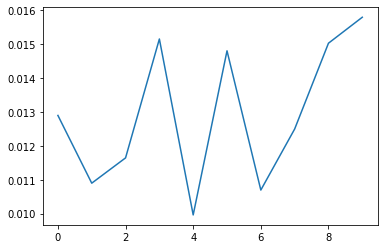

In [28]:
# display obserbables
Bmodel = tf.keras.Model(inputs = xin, outputs=[nboson,Htotal,Vtotal, Ktotal, Ntotal,d])    # print model
nbosonout, Hout, Vout, Kout, Nout,dout=Bmodel(xtrain) 
print(nbosonout)
print(tf.math.reduce_sum(nbosonout))
print("H="+repr(Hout.numpy()))
print("K="+repr(Kout.numpy()))
print("V="+repr(Vout.numpy()))
print("N="+repr(Nout.numpy()))
plt.plot(nbosonout[0])

## Train

In [29]:
total_trainable_parameters=np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print("Model trainable weights "+repr(total_trainable_parameters))

Model trainable weights 240


In [30]:
%%time
# train
# timing after the first run of training that takes around a duobled time
# N=32 100 epochs in 5.3 s in portatilegrande with noGPU
# N=32 100 epochs in 11.7 s in portatilegrande with GPU
# N=32 hawaii 1000 epocs 2 minuti no gpu
# N=32 hawaii 10000 epocs 20 minuti no gpu
# N=32 hawaii 10000 epocs 43 minuti with gpu

print("Training model for epochs "+repr(max_number_epochs)+" ...")

if max_number_epochs>0:
    history=model.fit(xtrain,ytrain,epochs=max_number_epochs,verbose=0, callbacks=[CustomCallback()])    
    print("Initial loss "+repr(history.history['loss'][0]))
    print("  Final loss "+repr(history.history['loss'][-1]))
    print(" ################################### ")
results=model.evaluate(xtrain,ytrain)

Training model for epochs 1000 ...
Epoch 0 of 1000 time numpy.datetime64('2023-03-29T05:58:37') H=-0.166 N=0.129 DN=0.984
Made checkpoint at total epoch 0
Epoch 100 of 1000 time numpy.datetime64('2023-03-29T05:58:41') H=-0.835 N=0.73 DN=0.92
Made checkpoint at total epoch 100
Epoch 200 of 1000 time numpy.datetime64('2023-03-29T05:58:45') H=-2.767 N=2.181 DN=0.758
Made checkpoint at total epoch 200
Epoch 300 of 1000 time numpy.datetime64('2023-03-29T05:58:49') H=-7.105 N=4.401 DN=0.491
Made checkpoint at total epoch 300
Epoch 400 of 1000 time numpy.datetime64('2023-03-29T05:58:53') H=-13.806 N=6.881 DN=0.251
Made checkpoint at total epoch 400
Epoch 500 of 1000 time numpy.datetime64('2023-03-29T05:58:58') H=-20.228 N=8.791 DN=0.132
Made checkpoint at total epoch 500
Epoch 600 of 1000 time numpy.datetime64('2023-03-29T05:59:02') H=-23.728 N=9.697 DN=0.093
Made checkpoint at total epoch 600
Epoch 700 of 1000 time numpy.datetime64('2023-03-29T05:59:07') H=-24.906 N=9.961 DN=0.083
Made check

In [31]:
# save model and arrays
model.save_weights(claudio_weights_file)
np.savez(claudio_arrays_file,history_H=history_H,history_N=history_N,
         history_eig=history_eig,history_negativity=history_negativity)
max_number_epochs

1000

Text(0.5, 1.0, 'logarithmic negativity')

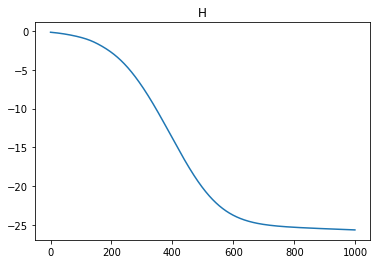

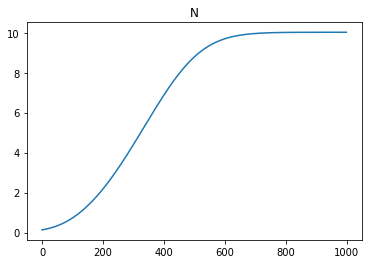

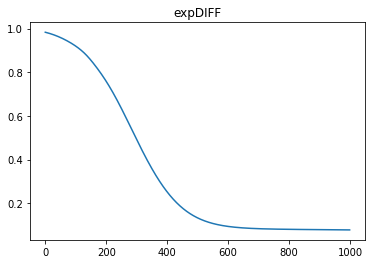

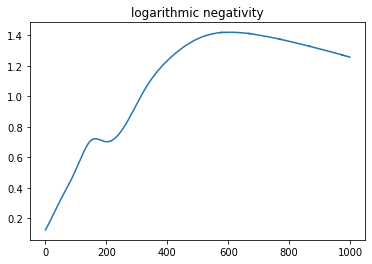

In [45]:
plt.figure(1)
plt.plot(history_H)
plt.title("H")
plt.figure(2)
plt.plot(history_N)
plt.title("N")
plt.figure(3)
plt.plot(np.real(history_expDIFF))
plt.title("expDIFF")
plt.figure(4)
plt.plot(history_negativity)
plt.title("logarithmic negativity")

tf.Tensor([[0.5632 0.5616 0.5638 0.6089 2.7171 2.7012 0.6186 0.5631 0.5642 0.5614]], shape=(1, 10), dtype=float32)
tf.Tensor(10.023116, shape=(), dtype=float32)
H=-25.61037
K=-5.6945205
V=-19.91585
N=10.023116
orderparameter=-0.2604105


Text(0.5, 1.0, '<Dn>')

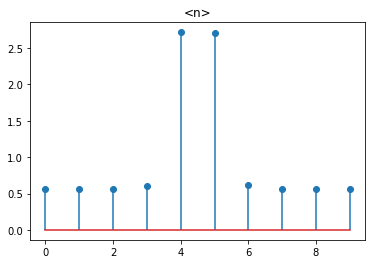

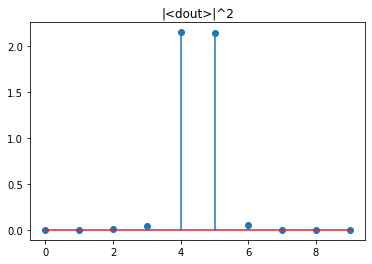

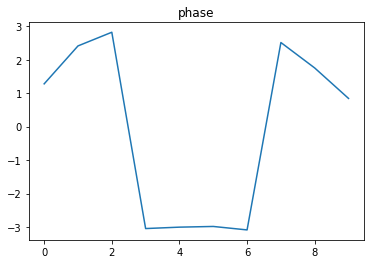

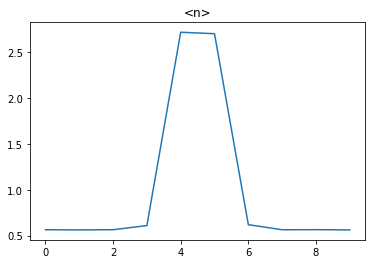

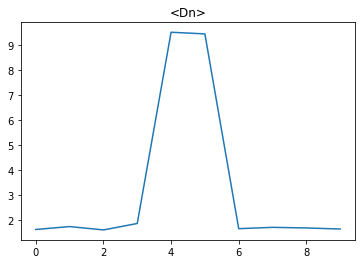

In [46]:
Bmodel = tf.keras.Model(inputs = xin, outputs=[nboson,nboson2,Htotal,Vtotal, Ktotal, Ntotal,cov, d])    # print model
nbosonout,nbosonout2, Hout, Vout, Kout, Nout,covout, dout=Bmodel(xtrain) 
print(nbosonout)
print(tf.math.reduce_sum(nbosonout))
print("H="+repr(Hout.numpy()))
print("K="+repr(Kout.numpy()))
print("V="+repr(Vout.numpy()))
print("N="+repr(Nout.numpy()))
print("orderparameter="+repr(np.mean(dout.numpy())))

plt.figure(6)
plt.stem(nbosonout[0])
plt.title('<n>')
plt.figure(7)
tmpr=dout[0][0::2].numpy()
tmpi=dout[0][1::2].numpy()
a2=0.5*(tmpr**2+tmpi**2)
fase=np.angle(tmpr+1j*tmpi)
plt.stem(a2)
plt.title('|<dout>|^2')
plt.figure(8)
plt.plot(fase)
plt.title('phase')
plt.figure(10)
plt.plot(nbosonout[0])
plt.title('<n>')
plt.figure(11)
plt.plot(nbosonout2[0]-nbosonout[0]**2)
plt.title('<Dn>')

# Compute the partial transpose and the degree of entanglement on the peaks

In [47]:
# covariance matrix
cov_np=covout.numpy()
# take a vector of n elements, with 1 for each mode to be trasponsed
nmask=np.zeros(n)
nmask[nA]=1
# build a diagonal with -1 corresponding to the momenta to be transposed
diag1=np.ones(N, dtype=np_real)
for j in range(n):
    if nmask[j]==1:
        diag1[j+1]=-1
# build the transformation matrix
Ftrans=np.diag(diag1)
# transform the covariance matrix
cov_np_Ta=np.matmul(Ftrans, np.matmul(cov_np, Ftrans))
qs.entanglement_entropy(cov_np_Ta)


Warning, entropy, unexpected eig 0.25599763


1.3398010163293252

In [48]:
nmask.shape

(10,)

In [49]:
# determinant of covariance matrix
np.linalg.det(cov_np)

1.0000011

In [50]:
nmask=np.zeros(n)
nmask[nA]=1
nmask[nB]=0
print(nmask)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [51]:
ENeg, Neg, seigs, ev, sv=qs.logarithmic_negativity(cov_np,nmask)


In [52]:
print(ENeg)
print(Neg)
print(seigs)
print(ev)


1.2562913633804662
0.6944043818868244
[0.2093 0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    1.1944]
[1.4266+5.1092e-08j 1.4266-5.1092e-08j 0.0438+3.6455e-08j
 0.0438-3.6455e-08j 0.25  +2.4430e-08j 0.25  -2.4430e-08j
 0.25  +8.0396e-09j 0.25  -8.0396e-09j 0.25  +4.5005e-08j
 0.25  -4.5005e-08j 0.25  +1.2418e-08j 0.25  -1.2418e-08j
 0.25  +1.6265e-09j 0.25  -1.6265e-09j 0.25  +5.1170e-08j
 0.25  -5.1170e-08j 0.25  +3.9787e-08j 0.25  -3.9787e-08j
 0.25  +2.3217e-08j 0.25  -2.3217e-08j]


In [53]:
sv.shape

(20, 20)

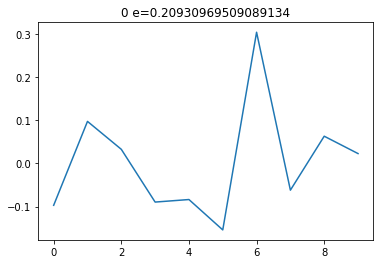

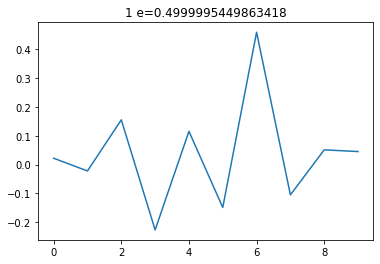

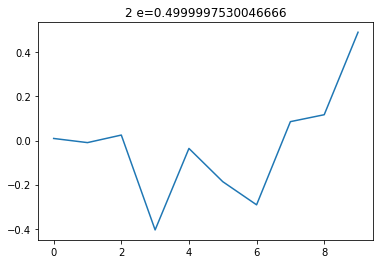

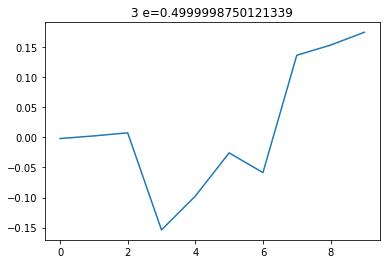

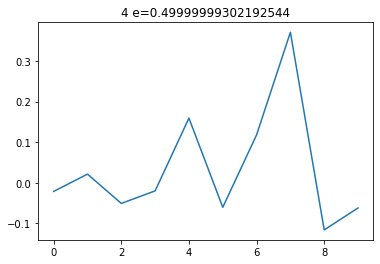

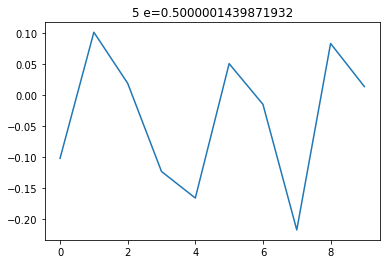

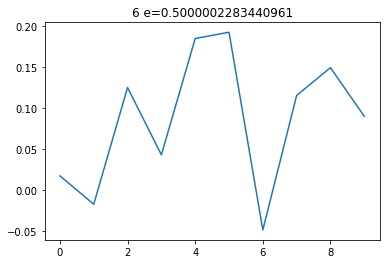

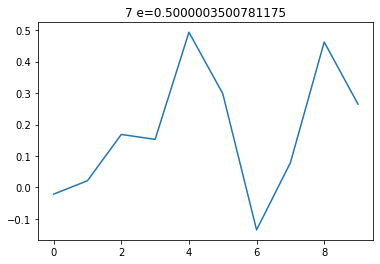

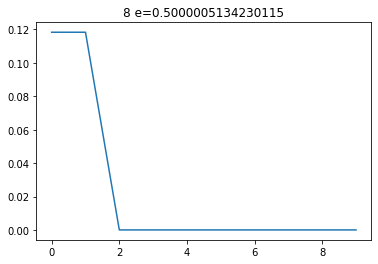

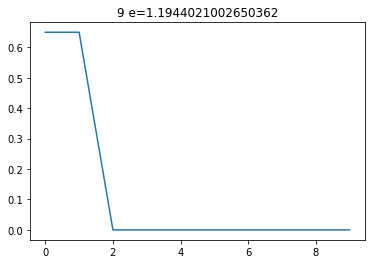

In [54]:
for i in range(n):
    svr=np.real(sv[i,0::2])
    plt.figure()
    asv=svr
    plt.plot(asv)
    plt.title(repr(i)+" e="+repr(seigs[i]))

In [55]:
sv[9]

array([ 6.4982e-01+0.0000e+00j,  6.4982e-01-0.0000e+00j,
        6.4982e-01+0.0000e+00j,  6.4982e-01-0.0000e+00j,
       -1.7203e-07-2.9991e-07j, -1.7203e-07+2.9991e-07j,
       -1.1117e-07+2.3966e-07j, -1.1117e-07-2.3966e-07j,
        1.5137e-07+1.1552e-07j,  1.5137e-07-1.1552e-07j,
        1.5168e-07-1.3817e-07j,  1.5168e-07+1.3817e-07j,
        3.1657e-07+9.6747e-08j,  3.1657e-07-9.6747e-08j,
        1.8906e-07-3.3526e-07j,  1.8906e-07+3.3526e-07j,
       -2.7070e-08-4.1004e-08j, -2.7070e-08+4.1004e-08j,
       -5.7343e-08-4.4897e-07j, -5.7343e-08+4.4897e-07j])

3**2

# Boson sampling the model

In [43]:
if not(BosonSampling):
    raise Exception("Finished code")

Exception: Finished code

## Make the Q-trasform of the model

In [56]:
kin, Qrho=qx.getQTransformModel(PSImodel)
Qfun = qx.QTransform(covout,dout)

In [57]:
Qrho.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             660       
 rmLayer)                                                        
                                                                 
Total params: 660
Trainable params: 240
Non-trainable params: 420
_________________________________________________________________


### Probability of all 0

In [58]:
qx.Pr([0]*n, Qfun)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0049]], dtype=float32)>

### Probability of bosons in soliton A 

In [59]:
nsample=[0]*n

In [60]:
nsample[nA]=1

In [61]:
print(nsample)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [62]:
qx.Pr(nsample, Qfun)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0045], dtype=float32)>

In [63]:
nsample[nA]=5

In [64]:
qx.Pr(nsample, Qfun)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.003], dtype=float32)>

### Probability of bosons in soliton B 

In [65]:
nsample=[0]*n

In [66]:
nsample[nB]=3

In [67]:
qx.Pr(nsample, Qfun)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0041], dtype=float32)>

###  Probability of bosons not in soliton A and B

In [68]:
nsample=[0]*n

In [69]:
nsample[nA-1]=3; print(nsample)

[0, 0, 0, 3, 0, 0, 0, 0, 0, 0]


In [70]:
qx.Pr(nsample, Qfun)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0002], dtype=float32)>

### Probability of a pair out of soliton A and B

In [71]:
nsample=[0]*n

In [72]:
nsample[nA]=1; nsample[nB]=1; print(nsample)

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [73]:
%%time
qx.Pr(nsample, Qfun)

CPU times: user 89.5 ms, sys: 3.83 ms, total: 93.3 ms
Wall time: 92.4 ms


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0031], dtype=float32)>

### Probability of a pair in soliton A and in the second site

In [74]:
nsample=[0]*n; nsample[nA]=1;nsample[0]=1;print(nsample)

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [75]:
%%time
qx.Pr(nsample, Qfun)

CPU times: user 118 ms, sys: 182 µs, total: 118 ms
Wall time: 117 ms


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0005], dtype=float32)>

### Probability in nA and in other sites

#### 1 photon

Processing j 0
Processing j 1
Processing j 2
Processing j 3
Processing j 4
Processing j 5
Processing j 6
Processing j 7
Processing j 8
Processing j 9
CPU times: user 519 ms, sys: 27 µs, total: 519 ms
Wall time: 519 ms


<StemContainer object of 3 artists>

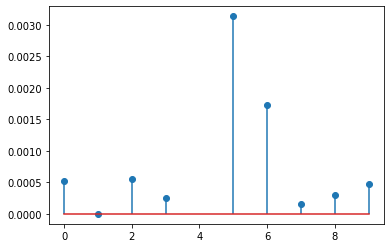

In [76]:
%%time
nphoton=1
location=nA
out=[0]*(n-1)
indeces=[0]*(n-1)
count=0
for ij in range(n):
    print("Processing j "+repr(ij))
    nsample=[0]*n
    nsample[location]=nphoton
    if ij!=location:
        nsample[ij]=nphoton
        out[count]=qx.Pr(nsample, Qfun)
        indeces[count]=ij
        count=count+1
plt.stem(indeces,out)

#### 2 photons

Processing j 0
Processing j 1
Processing j 2
Processing j 3
Processing j 4
Processing j 5
Processing j 6
Processing j 7
Processing j 8
Processing j 9
CPU times: user 15.7 s, sys: 9.47 ms, total: 15.7 s
Wall time: 15.7 s


<StemContainer object of 3 artists>

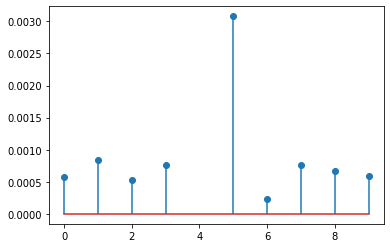

In [77]:
%%time
nphoton=2
location=nA
out=[0]*(n-1)
indeces=[0]*(n-1)
count=0
for ij in range(n):
    print("Processing j "+repr(ij))
    nsample=[0]*n
    nsample[location]=nphoton
    if ij!=location:
        nsample[ij]=nphoton
        out[count]=qx.Pr(nsample, Qfun)
        indeces[count]=ij
        count=count+1
plt.stem(indeces,out)

#### 3 photons

In [78]:
%%time
nphoton=3
location=nA
out=[0]*(n-1)
indeces=[0]*(n-1)
count=0
for ij in range(n):
    print("Processing j "+repr(ij))
    nsample=[0]*n
    nsample[location]=nphoton
    if ij!=location:
        nsample[ij]=nphoton
        out[count]=qx.Pr(nsample, Qfun)
        indeces[count]=ij
        count=count+1
plt.stem(indeces,out)

Processing j 0
Processing j 1
Processing j 2
Processing j 3
Processing j 4
Processing j 5
Processing j 6


KeyboardInterrupt: 

# PLOT MODEL

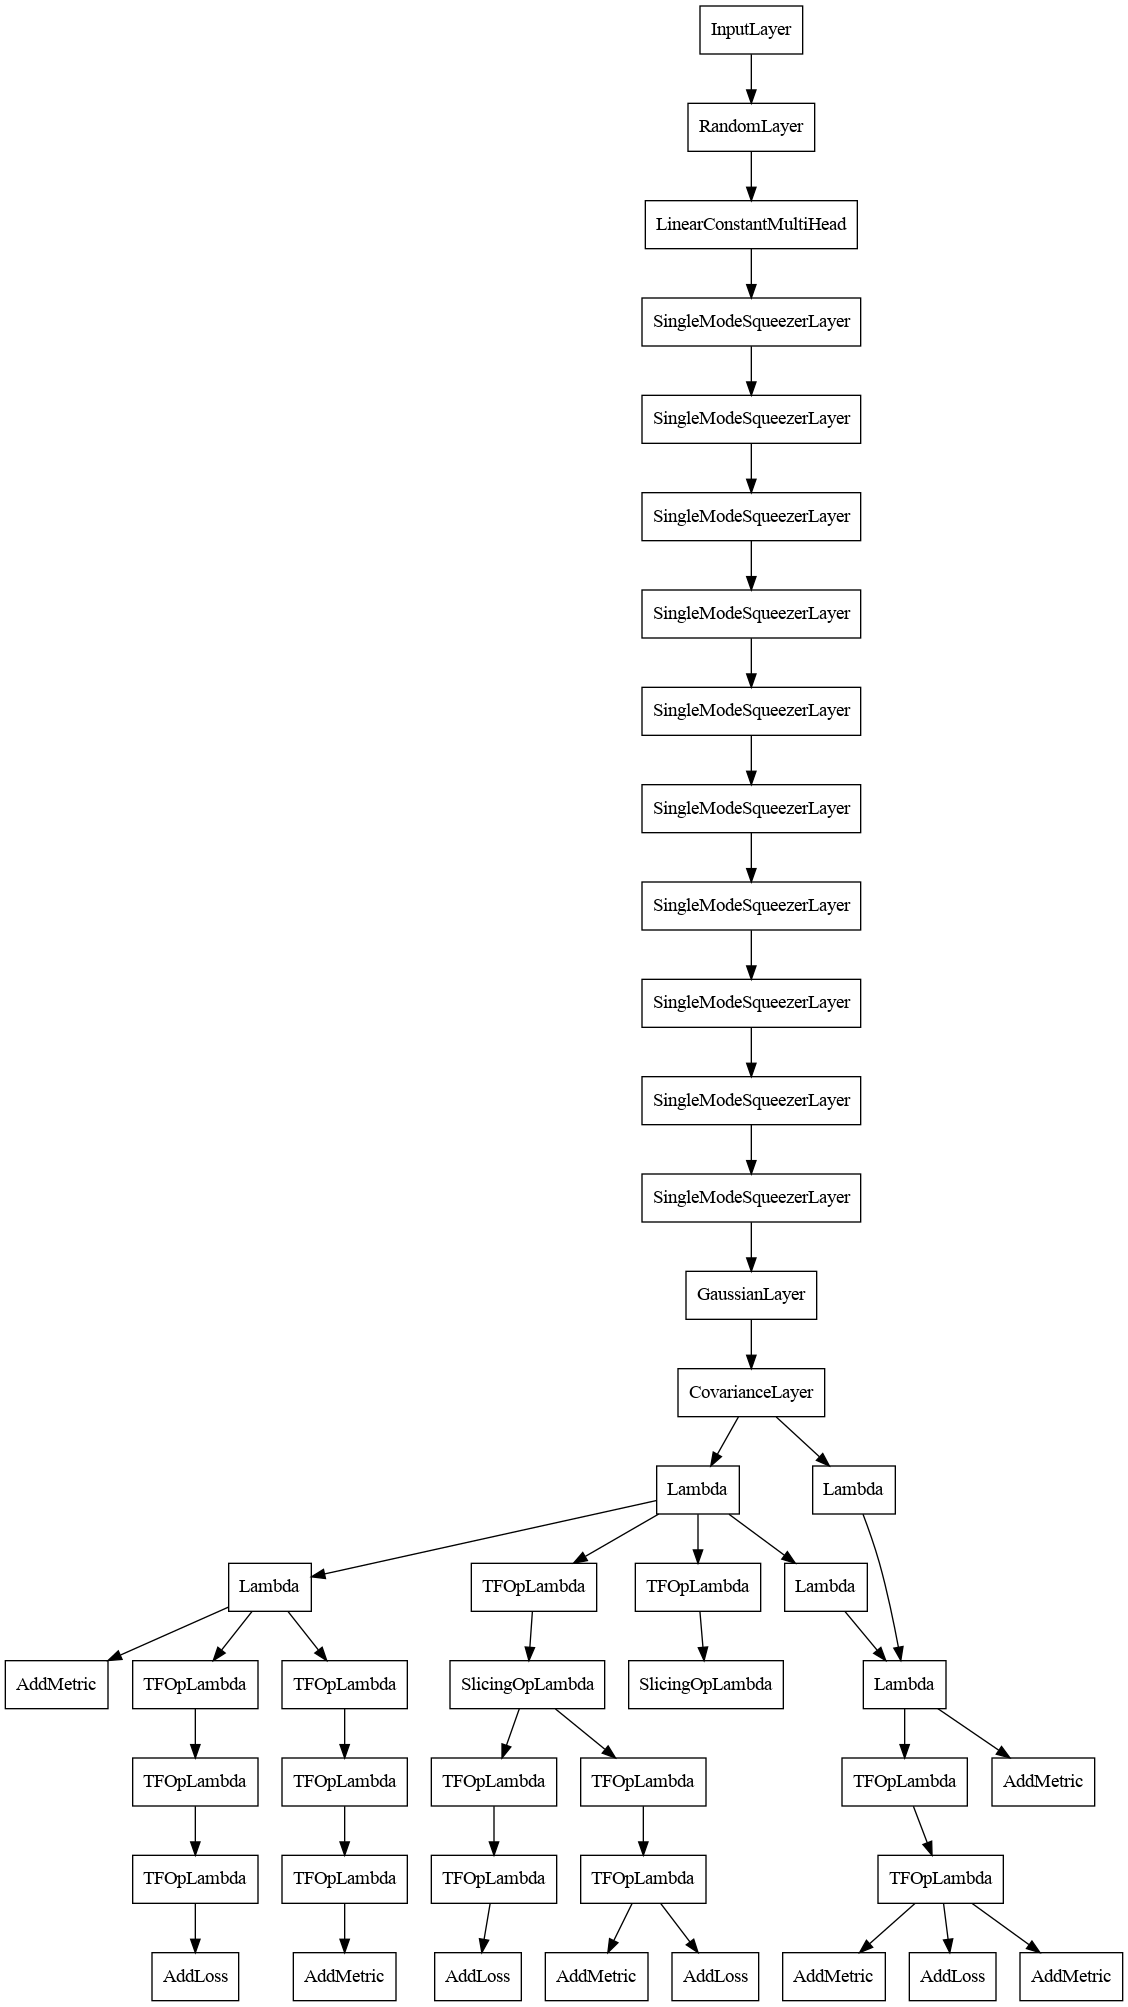

In [79]:
tf.keras.utils.plot_model(model, show_layer_names=False)